<a href="https://colab.research.google.com/github/nbht98/attack_cat_or_dog_classification/blob/master/Attack_with_synthetic_data_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
!wget https://raw.githubusercontent.com/nbht98/attack_cat_or_dog_classification/master/cord.json
!wget https://raw.githubusercontent.com/nbht98/attack_cat_or_dog_classification/master/cord.h5

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

from keras.models import model_from_json

# Model reconstruction from JSON file
with open('cord.json', 'r') as f:
    target_model = model_from_json(f.read())

# Load weights into the new model
target_model.load_weights('cord.h5')

!pip3 install mia
# Import library 
import numpy as np

from absl import app
from absl import flags

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data

def attack_model_fn():
    """Attack model that takes target model predictions and predicts membership.
    Following the original paper, this attack model is specific to the class of the input.
    AttachModelBundle creates multiple instances of this model for each class.
    """
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(128, activation="relu", input_shape=(NUM_CLASSES,)))

    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))

    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

def target_model_fn():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

Using TensorFlow backend.


--2019-12-13 06:18:50--  https://raw.githubusercontent.com/nbht98/attack_cat_or_dog_classification/master/cord.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6533 (6.4K) [text/plain]
Saving to: ‘cord.json.2’

cord.json.2         100%[===================>]   6.38K  --.-KB/s    in 0s      

2019-12-13 06:18:50 (132 MB/s) - ‘cord.json.2’ saved [6533/6533]

--2019-12-13 06:18:54--  https://raw.githubusercontent.com/nbht98/attack_cat_or_dog_classification/master/cord.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51813824 (49M) [applic

In [0]:
import cv2
sample0 = '0a.jpg'
image0 = cv2.imread(sample0, cv2.IMREAD_COLOR)
res0 = cv2.resize(image0, dsize=(128, 128))

image_0 = np.array(res0)

sample1 = '1.jpg'
image1 = cv2.imread(sample1, cv2.IMREAD_COLOR)
res1 = cv2.resize(image1, dsize=(128, 128))

image_1 = np.array(res1)


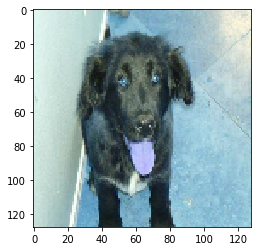

In [152]:
plt.imshow(np.squeeze(image_1))

In [153]:
t_model.predict_proba(image_1.reshape(1, 128*3//3, 128, 3))

array([[0., 1.]], dtype=float32)

In [0]:
def features_generator(n_features: tuple, dtype: str, rang: tuple = (0, 255)) -> np.ndarray:
    """
    Creates a n features vector with uniform features
    sampled from a given range.
    Parameters
    ----------
    n_features: tuple
        number of features
    dtype: str
        type of the features. All the features must will have the same type.
    rang: tuple(int, int)
        range of the random uniform population from
        where to drawn samples
    Returns
    -------
    np.ndarray
        features vector
    """
    # D-fence params
    if dtype not in ("bool", "int", "float"):
        raise ValueError("Parameter `dtype` must be 'bool', 'int' or 'float'")
    if dtype == "bool":
        x = np.random.randint(0, 2, size=n_features)
    if dtype == "int":
        x = np.random.randint(rang[1], size=n_features)
    if dtype == "float":
        x = np.random.uniform(rang[0], rang[1], n_features)
    return x.reshape((n_features[0], n_features[1]))


def feature_randomizer(x: np.ndarray, n_features: tuple, k: int, dtype: str, rang: tuple = (0, 255), vertical=True) -> np.ndarray:
    """
    Randomizes k features from feature vector x
    Parameters
    ----------
    x: np.ndarray
        input array that will be modified
    k: int
        number of features to modify
    dtype: str
        type of the features. It only accepts uniform dtype.
    rang: tuple(int, int)
        range of the random uniform population from 
        where to drawn samples
    Returns
    -------
    x: np.ndarray
        input vector with k modified features
    """
    if vertical:
      idx_to_change = np.random.randint(0, n_features[1], size=k)
      new_feats = features_generator(n_features=(n_features[0], k), dtype="int", rang=rang)
      x[:,idx_to_change] = new_feats
    else:
      idx_to_change = np.random.randint(0, n_features[0], size=k)
      new_feats = features_generator(n_features=(k, n_features[1]), dtype="int", rang=rang)
      x[idx_to_change] = new_feats
    return x


def synthesize(
    target_model, sample: np.ndarray, fixed_cls: int, k_max: int, dtype: str="int", n_features: tuple = (128*3,128), vertical=True) -> np.ndarray:
    """
    Generates synthetic records that are classified
    by the target model with high confidence.
    Parameters
    ----------
    target_model: estimator
        Estimator that returns a class probability vector
        from an input features vector. Implemented for
        sklearn.base.BaseEstimator with `predict_proba()`
        method.
    fixed_cls: int
        target model class to create data point from
    k_max: int
        max "radius" of feature perturbation
    
    dtype: str
        dtype of the features (float, int, bool)
    n_features: int
        number of features per input vector
    
    Returns
    -------
    np.ndarray
        synthetic feature vector
    False
        If failed to synthesize vector.
        This may be becaus number of iters exceded
    """

    # if not hasattr(target_model, "predict_proba"):
    #     raise AttributeError("target_model must have predict_proba() method")

    # if not hasattr(target_model, "n_features_") and n_features is None:
    #     raise ValueError("please specify the number of features in `n_features`")
    # else:
    #     n_features = target_model.n_features_

    # x = features_generator(n_features, dtype=dtype, rang=(0,255))  # random record

    y_c_current = 0  # target model’s probability of fixed class
    n_rejects = 0  # consecutives rejections counter
    k = k_max
    k_min = 1
    max_iter = 10
    conf_min = 0.2  # min prob cutoff to consider a record member of the class
    rej_max = 5  # max number of consecutive rejections

    x = np.array(sample, copy=True)
    x = x.reshape(-1, x.shape[1])
    x = feature_randomizer(x, n_features, k, dtype='int', rang=(0, 255), vertical=vertical)

    for _ in range(max_iter):
        y = target_model.predict_proba(x.reshape(1, n_features[0]//3, n_features[1], 3))  # query target model
        y_c = y.flat[fixed_cls]
        if y_c >= y_c_current:
            if (y_c > conf_min) and (fixed_cls == np.argmax(y)):
                return x.reshape(1, n_features[0]//3, n_features[1], 3), y
            # reset vars
            x_new = x
            y_c_current = y_c
            n_rejects = 0
        else:
            n_rejects += 1
            if n_rejects > rej_max:
                k = max(k_min, int(np.ceil(k / 2)))
                n_rejects = 0
        # x = feature_randomizer(x_new, k, dtype=dtype, rang=(0, 1))
        # x_new = feature_randomizer(x, 3, dtype="int", rang=(0, 255))
        x = feature_randomizer(x_new, n_features, k, dtype='int', rang=(0, 255), vertical=vertical)
    return False, False



In [0]:
x = synthesize(t_model, image_1, 1, 128 * 3,'int', (128*3,128),False)
plt.imshow(np.squeeze(x[0]))

In [0]:

def synthesize_batch(target_model, n_features, lst_class, lst_sample, n_records, k_max, vertical=True):
    """
    Synthesize a batch of records
    """
    x_synth = np.zeros((n_records,n_features[0]//3,n_features[1], 3))
    y_synth = np.zeros((n_records, 2))
    count = 0
    for i in range(n_records//2):
      print(i)
      for j in lst_class:
        if j == 0:
          k_max = n_features[0] * 3
          vertical = True
        else:
          k_max = n_features[1]
          vertical = False
        while True:  # repeat until synth finds record
            x, y = synthesize(target_model, lst_sample[j], fixed_cls=j, k_max=k_max, n_features=n_features, vertical=vertical)
            if isinstance(x, np.ndarray):
                break
        x_synth[count] = x
        y_synth[count] = y
        count += 1
    return x_synth, y_synth



In [178]:
attack = synthesize_batch(t_model, (128*3,128), [0,1], [image_0, image_1], 4000, 128)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [189]:

NUM_CLASSES = 2
SHADOW_DATASET_SIZE = 4000
ATTACK_TEST_DATASET_SIZE = 4000


TARGET_EPOCHS = 15 # Number of epochs to train target and shadow models
ATTACK_EPOCHS = 15 # Number of epochs to train attack models.
NUM_SHADOWS = 3 # Number of epochs to train attack models.

# Train the shadow models.
smb = ShadowModelBundle(
    target_model_fn,
    shadow_dataset_size=SHADOW_DATASET_SIZE,
    num_models=NUM_SHADOWS,
)

# attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(
#     attack[0], attack[1], test_size=0.1
# )


attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(
    test_x[:10000], test_y[:10000], test_size=0.1
)

print("Training the shadow models...")
X_shadow, y_shadow = smb.fit_transform(
    attacker_X_train,
    attacker_y_train,
    fit_kwargs=dict(
        epochs=12,
        verbose=True,
        validation_data=(attacker_X_test,attacker_y_test),
    ),
)

Training the shadow models...
Train on 4000 samples, validate on 1000 samples
Epoch 1/12
4000/4000 [==============================] - 6s 1ms/step - loss: 1.1000 - acc: 0.5853 - val_loss: 1.1835 - val_acc: 0.5400
Epoch 2/12
4000/4000 [==============================] - 3s 816us/step - loss: 0.7603 - acc: 0.6282 - val_loss: 1.5424 - val_acc: 0.5200
Epoch 3/12
4000/4000 [==============================] - 3s 814us/step - loss: 0.6291 - acc: 0.6820 - val_loss: 0.9284 - val_acc: 0.5880
Epoch 4/12
4000/4000 [==============================] - 3s 822us/step - loss: 0.5387 - acc: 0.7308 - val_loss: 0.6840 - val_acc: 0.6530
Epoch 5/12
4000/4000 [==============================] - 3s 814us/step - loss: 0.4609 - acc: 0.7855 - val_loss: 0.5379 - val_acc: 0.7490
Epoch 6/12
4000/4000 [==============================] - 3s 824us/step - loss: 0.3971 - acc: 0.8173 - val_loss: 0.6571 - val_acc: 0.7190
Epoch 7/12
4000/4000 [==============================] - 3s 822us/step - loss: 0.3379 - acc: 0.8535 - val_los

In [190]:
# ShadowModelBundle returns data in the format suitable for the AttackModelBundle.
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)

# Fit the attack models.
print("Training the attack models...")
amb.fit(
    X_shadow, y_shadow, fit_kwargs=dict(epochs=ATTACK_EPOCHS, verbose=True)
)

Training the attack models...
Train on 11822 samples
Epoch 1/15
11822/11822 [==============================] - 1s 110us/sample - loss: 0.6355 - acc: 0.6271
Epoch 2/15
11822/11822 [==============================] - 1s 74us/sample - loss: 0.6282 - acc: 0.6379
Epoch 3/15
11822/11822 [==============================] - 1s 75us/sample - loss: 0.6264 - acc: 0.6405
Epoch 4/15
11822/11822 [==============================] - 1s 74us/sample - loss: 0.6247 - acc: 0.6434
Epoch 5/15
11822/11822 [==============================] - 1s 73us/sample - loss: 0.6242 - acc: 0.6449
Epoch 6/15
11822/11822 [==============================] - 1s 73us/sample - loss: 0.6245 - acc: 0.6430
Epoch 7/15
11822/11822 [==============================] - 1s 75us/sample - loss: 0.6230 - acc: 0.6428
Epoch 8/15
11822/11822 [==============================] - 1s 73us/sample - loss: 0.6240 - acc: 0.6405
Epoch 9/15
11822/11822 [==============================] - 1s 74us/sample - loss: 0.6238 - acc: 0.6431
Epoch 10/15
11822/11822 [===

In [16]:
import os
os.environ['KAGGLE_USERNAME'] = "aozora98" # username from the json file
os.environ['KAGGLE_KEY'] = "b8d4dd5c0f9d91084dde1befbdc2c4d3" # key from the json file
!kaggle competitions download -c dogs-vs-cats

!unzip test1.zip
!unzip train.zip

 97% 262M/271M [00:07<00:00, 41.5MB/s]
100% 271M/271M [00:07<00:00, 39.8MB/s]
 98% 534M/543M [00:03<00:00, 211MB/s]
100% 543M/543M [00:03<00:00, 161MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 71.7MB/s]
Archive:  test1.zip
   creating: test1/
  inflating: test1/1.jpg             
  inflating: test1/10.jpg            
  inflating: test1/100.jpg           
  inflating: test1/1000.jpg          
  inflating: test1/10000.jpg         
  inflating: test1/10001.jpg         
  inflating: test1/10002.jpg         
  inflating: test1/10003.jpg         
  inflating: test1/10004.jpg         
  inflating: test1/10005.jpg         
  inflating: test1/10006.jpg         
  inflating: test1/10007.jpg         
  inflating: test1/10008.jpg         
  inflating: test1/10009.jpg         
  inflating: test1/1001.jpg          
  inflating: test1/10010.jpg         
  inflating: test1/10011.jpg         
  inflating: test1/10012.jpg         
  inflating: test1/10013.jpg         
  inflating

In [4]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=len(train_df)


train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [0]:
train_df.to_csv('train_df', sep='\t', encoding='utf-8')

In [5]:
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=1000,
    shuffle=False
)

predict = target_model.predict_generator(test_generator, steps=np.ceil(nb_samples/1000))

t_df = test_df[:12500]

t_df['category'] = np.argmax(predict[:12500], axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
t_df['category'] = t_df['category'].replace(label_map)
# t_df['category'] = t_df['category'].replace({ 'dog': 1, 'cat': 0 })

Found 12500 validated image filenames.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


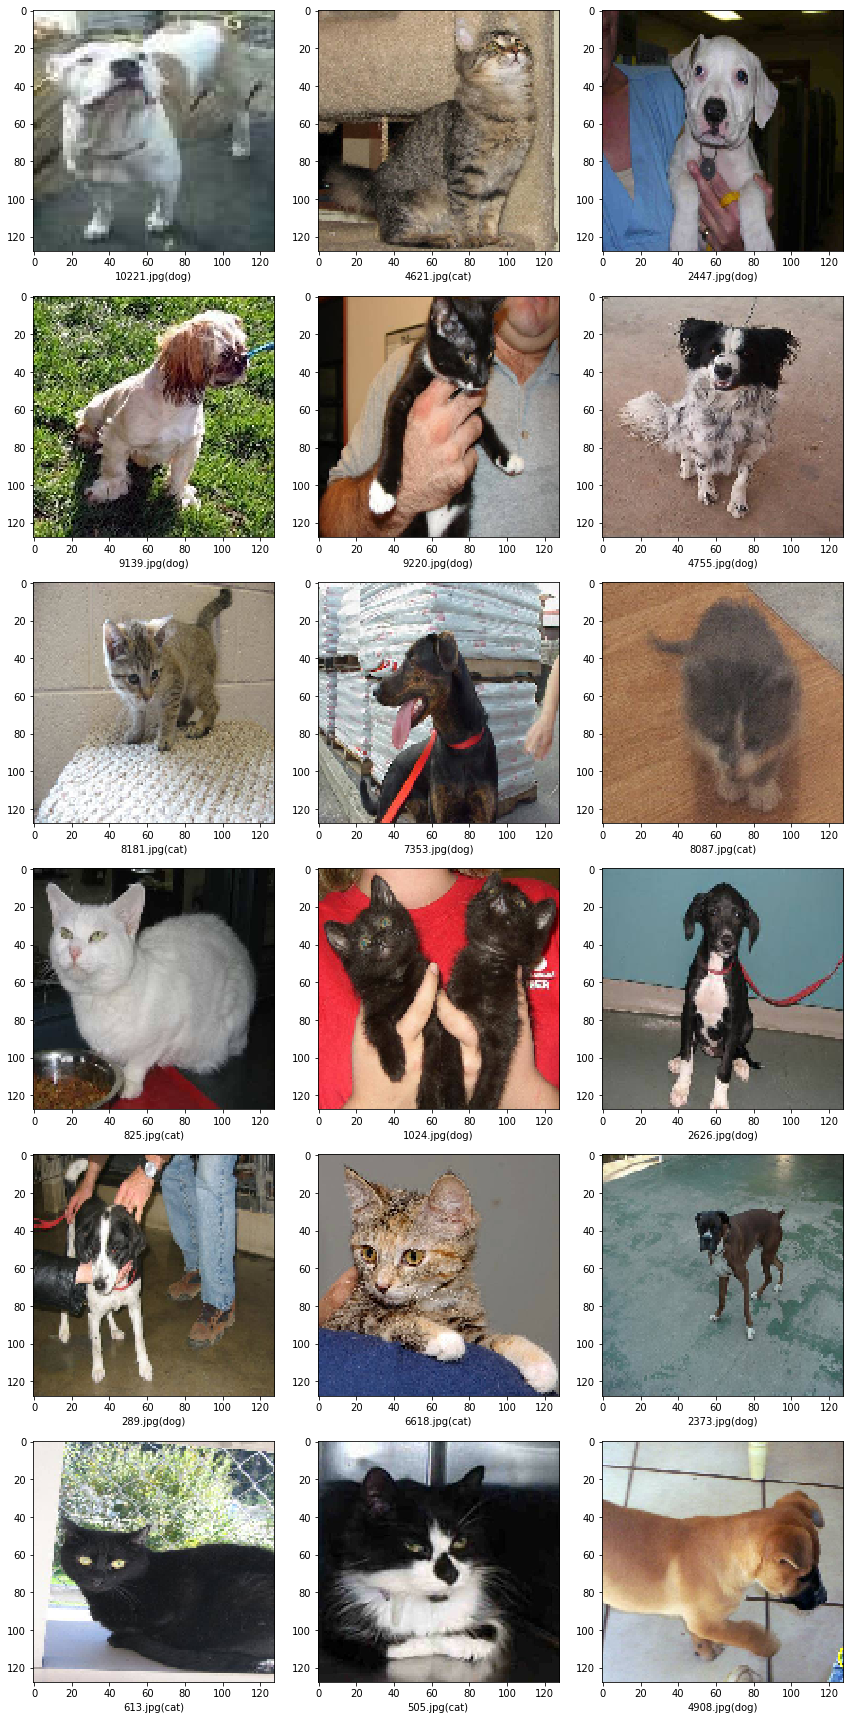

In [17]:
sample_test = t_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [0]:
t_df

In [6]:
batch_size=12500

t_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

t_generator = t_datagen.flow_from_dataframe(
    t_df[:12500], 
    "./test1", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 12500 validated image filenames belonging to 2 classes.


In [0]:
train_x = train_generator[0][0]
train_y = train_generator[0][1]
valid_x = validation_generator[0][0]
valid_y = validation_generator[0][1]
test_x = t_generator[0][0]
test_y = t_generator[0][1]

In [0]:
t_model = target_model_fn()


In [143]:
t_model.fit(
    train_x, train_y, epochs=25, validation_data=(valid_x, valid_y), verbose=True
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 17s 831us/step - loss: 0.0914 - acc: 0.9669 - val_loss: 0.8529 - val_acc: 0.8280
Epoch 2/25
20000/20000 [==============================] - 17s 825us/step - loss: 0.0889 - acc: 0.9675 - val_loss: 0.5163 - val_acc: 0.8544
Epoch 3/25
20000/20000 [==============================] - 17s 826us/step - loss: 0.0942 - acc: 0.9675 - val_loss: 0.5238 - val_acc: 0.8424
Epoch 4/25
20000/20000 [==============================] - 17s 826us/step - loss: 0.0874 - acc: 0.9696 - val_loss: 0.5564 - val_acc: 0.8592
Epoch 5/25
20000/20000 [==============================] - 16s 825us/step - loss: 0.0976 - acc: 0.9675 - val_loss: 0.4804 - val_acc: 0.8706
Epoch 6/25
20000/20000 [==============================] - 16s 823us/step - loss: 0.0849 - acc: 0.9691 - val_loss: 0.5122 - val_acc: 0.8482
Epoch 7/25
20000/20000 [==============================] - 16s 820us/step - loss: 0.0828 - acc: 0.9707 - val_loss: 0.8

In [0]:
t_model.save('t_model.h5')


In [0]:
[train_x.shape, train_y.shape]


In [0]:
np.savetxt("train_y.csv", train_y, delimiter=',')

In [23]:
[test_x.shape, test_y.shape]

[(12500, 128, 128, 3), (12500, 2)]

In [24]:
[attack[0].shape, attack[1].shape]

[(6000, 128, 128, 3), (6000, 2)]

In [194]:
# Test the success of the attack.

# Prepare examples that were in the training, and out of the training.
data_in = train_x, train_y
data_out = test_x, test_y

# Compile them into the expected format for the AttackModelBundle.
attack_test_data, real_membership_labels = prepare_attack_data(
    t_model, data_in, data_out
)

# Compute the attack accuracy.
attack_guesses = amb.predict(attack_test_data)
attack_accuracy = np.mean(attack_guesses == real_membership_labels)

print(attack_accuracy)

0.6514769230769231
